In [2]:
!pip install swig
!pip install gymnasium
!pip install gymnasium[box2d]
!pip install gymnasium[classic-control]

In [3]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import cv2

# Hyperparameters
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_END = 0.1
EPSILON_DECAY = 1000
LEARNING_RATE = 0.0003
BATCH_SIZE = 64
#TARGET_UPDATE = 1000
MEMORY_SIZE = 100000
NUM_EPISODES = 300


In [4]:
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_shape, 512)
        self.fc2 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return x



In [5]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return (np.array(state), np.array(action), np.array(reward),
                np.array(next_state), np.array(done))

    def __len__(self):
        return len(self.buffer)

In [6]:
def select_action(state, epsilon, n_actions, policy_net):
    if random.random() > epsilon:
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            return policy_net(state).argmax(1).item()
    else:
        return random.randrange(n_actions)


In [7]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    state, action, reward, next_state, done = memory.sample(BATCH_SIZE)

    state = torch.FloatTensor(state).to(device)
    action = torch.LongTensor(action).to(device)
    reward = torch.FloatTensor(reward).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    done = torch.FloatTensor(done).to(device)

    q_values = policy_net(state)
    next_q_values = policy_net(next_state)
    next_q_state_values = policy_net(next_state)

    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value = next_q_state_values.gather(1, next_q_values.argmax(1).unsqueeze(1)).squeeze(1)
    expected_q_value = reward + GAMMA * next_q_value * (1 - done)

    loss = (q_value - expected_q_value.detach()).pow(2).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [8]:
env = gym.make('CartPole-v1')
input_shape = 4
num_actions = env.action_space.n

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

policy_net = DQN(input_shape, num_actions).to(device)

optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
memory = ReplayBuffer(MEMORY_SIZE)

epsilon = EPSILON_START
epsilon_decay = (EPSILON_START - EPSILON_END) / EPSILON_DECAY
steps_done = 0

episode_rewards = []

for episode in range(NUM_EPISODES):
    state, _ = env.reset()
    total_reward = 0

    for t in range(10000):
        action = select_action(state, epsilon, num_actions, policy_net)
        next_state, reward, done, _, _ = env.step(action)
        if(done and reward <= 0):
          reward = -1
        total_reward += reward

        memory.push(state, action, reward, next_state, done)

        state = next_state
        optimize_model()

        if done:
            break

        epsilon = max(EPSILON_END, epsilon - epsilon_decay)
        steps_done += 1


    episode_rewards.append(total_reward)
    print(f"Episode {episode + 1}, Total reward: {total_reward}")

env.close()




Episode 1, Total reward: 16.0
Episode 2, Total reward: 11.0
Episode 3, Total reward: 20.0
Episode 4, Total reward: 53.0
Episode 5, Total reward: 11.0
Episode 6, Total reward: 12.0
Episode 7, Total reward: 23.0
Episode 8, Total reward: 26.0
Episode 9, Total reward: 9.0
Episode 10, Total reward: 9.0
Episode 11, Total reward: 14.0
Episode 12, Total reward: 14.0
Episode 13, Total reward: 10.0
Episode 14, Total reward: 12.0
Episode 15, Total reward: 13.0
Episode 16, Total reward: 13.0
Episode 17, Total reward: 12.0
Episode 18, Total reward: 13.0
Episode 19, Total reward: 15.0
Episode 20, Total reward: 12.0
Episode 21, Total reward: 10.0
Episode 22, Total reward: 13.0
Episode 23, Total reward: 17.0
Episode 24, Total reward: 11.0
Episode 25, Total reward: 19.0
Episode 26, Total reward: 19.0
Episode 27, Total reward: 22.0
Episode 28, Total reward: 20.0
Episode 29, Total reward: 15.0
Episode 30, Total reward: 24.0
Episode 31, Total reward: 15.0
Episode 32, Total reward: 18.0
Episode 33, Total r

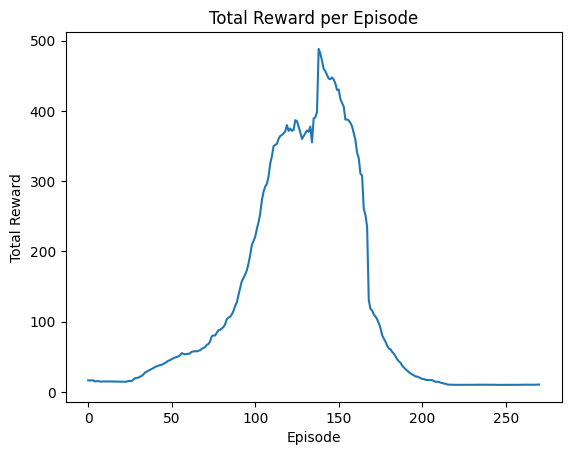

In [9]:
def moving_average(data, window_size):
    """
    Calculate the moving average of a given list of numbers.

    Parameters:
    - data: List of numbers.
    - window_size: Size of the moving window.

    Returns:
    - List of moving averages.
    """
    if len(data) < window_size:
        return []

    moving_averages = []
    for i in range(len(data) - window_size + 1):
        window = data[i:i + window_size]
        window_average = sum(window) / window_size
        moving_averages.append(window_average)

    return moving_averages

ma = moving_average(episode_rewards,30)

# Plot cumulative rewards
plt.plot(ma)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()